In [1]:
from item import *
import random
import numpy as np
import math
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
import json

random.seed()

In [2]:
class NetlistTransformer:
    MAX_INPUT_SIZE: int = 16384

    def __init__(self) -> None:
        self.ratio_condense: float = None
        self.num_nodes: int = None
        self.num_movable_nodes: int = None
        self.num_fixed_nodes: int = None
        self.num_edges: int = None
        self.num_pins: int = None
        self.num_supernodes: int = None
        self.movable_node_list: list[Node] = []
        self.fixed_node_list: list[Node] = []
        self.edge_list: list[Edge] = []
        self.supernode_list: list[SuperNode] = []
        self.superedge_list: list[SuperEdge] = []
        self.name2node: dict[str, Node] = {}
        self.width_die: int = None
        self.height_die: int = None
        self.die_boundary_x: tuple[int, int] = ()   # (left, right)
        self.die_boundary_y: tuple[int, int] = ()   # (bottom, top)
        self.num_rows: int = None
        self.height_row: int = None
        self.area_movable: int = None
        self.area_available: int = None

        # vectors or matrices, center coordinate, M: # movable nodes, F: # fixed nodes, E: # edges
        self.x_movable_nodes: np.ndarray = None         # 1D array, dim: M
        self.y_movable_nodes: np.ndarray = None         # 1D array, dim: M
        self.x_fixed_nodes: np.ndarray = None           # 1D array, dim: F
        self.y_fixed_nodes: np.ndarray = None           # 1D array, dim: F
        self.pseudo_weight_matrix: csr_matrix = None    # 2D array, dim: M*(M+F)
        self.hyper_adjacency_matrix: csr_matrix = None  # 2D array, dim: (M+F)*E
    
    def readFromTxt(self):
        pass

    def readFromBookshelf(self, circuitName = 'adaptec1', inputPath = '../benchmarks/'):
        # read from .nodes / .pl / .nets / .scl files

        def fileName(fileFormat: str) -> str:
            return inputPath + circuitName + '/' + circuitName + fileFormat
        
        # read .nodes file
        with open(fileName('.nodes'), 'r') as file:
            for line in file:
                words = line.split()
                if words[:1] == ['NumNodes']:
                    self.num_nodes = int(words[-1])
                    break
            for line in file:
                words = line.split()
                if words[:1] == ['NumTerminals']:
                    self.num_fixed_nodes = int(words[-1])
                    break
            self.num_movable_nodes = self.num_nodes - self.num_fixed_nodes

            for line in file:
                words = line.split()
                if len(words) == 3:
                    node = Node(len(self.movable_node_list))
                    node.name = words[0]
                    node.w = int(words[1])
                    node.h = int(words[2])
                    self.movable_node_list.append(node)
                    self.name2node[node.name] = node
                else:
                    node = Node(len(self.fixed_node_list) + self.num_movable_nodes)
                    node.name = words[0]
                    node.w = int(words[1])
                    node.h = int(words[2])
                    self.fixed_node_list.append(node)
                    self.name2node[node.name] = node

        # read .pl file
        self.x_movable_nodes = np.array([0] * self.num_movable_nodes)
        self.y_movable_nodes = np.array([0] * self.num_movable_nodes)
        self.x_fixed_nodes = np.array([0] * self.num_fixed_nodes)
        self.y_fixed_nodes = np.array([0] * self.num_fixed_nodes)
        with open(fileName('.pl'), 'r') as file:
            orientations = {'N', 'S', 'E', 'W', 'FN', 'FS', 'FE', 'FW'}
            for line in file:
                words = line.split()
                if len(words) >= 5 and words[3] == ':' and words[4] in orientations:
                    node = self.name2node[words[0]]
                    if len(words) == 5: # movalbe
                        self.x_movable_nodes[node.id] = float(words[1]) + node.w / 2
                        self.y_movable_nodes[node.id] = float(words[2]) + node.h / 2
                    else:   # fixed
                        self.x_fixed_nodes[node.id - self.num_movable_nodes] = float(words[1]) + node.w / 2
                        self.y_fixed_nodes[node.id - self.num_movable_nodes] = float(words[2]) + node.h / 2
            for line in file:
                words = line.split()
                node = self.name2node[words[0]]
                if len(words) == 5: # movalbe
                    self.x_movable_nodes[node.id] = float(words[1]) + node.w / 2
                    self.y_movable_nodes[node.id] = float(words[2]) + node.h / 2
                else:   # fixed
                    self.x_fixed_nodes[node.id - self.num_movable_nodes] = float(words[1]) + node.w / 2
                    self.y_fixed_nodes[node.id - self.num_movable_nodes] = float(words[2]) + node.h / 2

        # read .nets file
        with open(fileName('.nets'), 'r') as file:
            for line in file:
                words = line.split()
                if words[:1] == ['NumNets']:
                    self.num_edges = int(words[-1])
                    break
            for line in file:
                words = line.split()
                if words[:1] == ['NumPins']:
                    self.num_pins = int(words[-1])
                    break
            for line in file:
                words = line.split()
                if words[:1] == ['NetDegree']:
                    edge = Edge(len(self.edge_list))
                    edge.name = words[-1]
                    edge.degree = int(words[-2])
                    for i in range(edge.degree):
                        line = file.readline()
                        words = line.split()
                        node = self.name2node[words[0]]
                        x_offset = float(words[-2])
                        y_offset = float(words[-1])
                        if words[1] == 'I':
                            edge.in_pin_list.append((node, x_offset, y_offset))
                            node.in_pin_list.append((edge, x_offset, y_offset))
                        else:
                            edge.out_pin_list.append((node, x_offset, y_offset))
                            node.out_pin_list.append((edge, x_offset, y_offset))
                        edge.node_set.add(node)
                        node.edge_set.add(edge)
                    self.edge_list.append(edge)
        
        # read .scl file
        with open(fileName('.scl'), 'r') as file:
            for line in file:
                words = line.split()
                if words[:1] == ['NumRows']:
                    self.num_rows = int(words[-1])
                    break
            
            y_min = float('inf')
            for line in file:
                words = line.split()
                if words[:1] == ['CoreRow']:
                    line = file.readline()
                    y_min = min(y_min, int(line.split()[-1]))
                    line = file.readline()
                    self.height_row = int(line.split()[-1])
                    line = file.readline()
                    sitewidth = int(line.split()[-1])
                    line = file.readline()
                    sitespacing = int(line.split()[-1])
                    line = file.readline()
                    line = file.readline()
                    line = file.readline()
                    words = line.split()
                    subrowOrigin = int(words[2])
                    numSites = int(words[5])
                    left = subrowOrigin
                    right = subrowOrigin + (numSites - 1) * sitespacing + sitewidth
                    self.die_boundary_x = (left, right)
            bottom = int(y_min)
            top = int(y_min) + self.height_row * self.num_rows
            self.die_boundary_y = (bottom, top)
            self.width_die = self.die_boundary_x[1] - self.die_boundary_x[0]
            self.height_die = self.die_boundary_y[1] - self.die_boundary_y[0]
    
    def init(self):
        def randomCoorX() -> float:
            (x_low, x_high) = self.die_boundary_x
            return random.uniform(x_low, x_high)
        
        def randomCoorY() -> float:
            (y_low, y_high) = self.die_boundary_y
            return random.uniform(y_low, y_high)
        
        # randomly place
        for i in range(self.num_movable_nodes):
            self.x_movable_nodes[i] = randomCoorX()
            self.y_movable_nodes[i] = randomCoorY()
        
        # build pseudo weight matrix
        row = []
        col = []
        data = []
        
        for node in self.movable_node_list:
            w_total = 0
            for edge in node.edge_set:
                w = edge.pseudoWeight()
                if w > 0:
                    w_total += w * len(edge.node_set)
            if w_total == 0:
                break
            for edge in node.edge_set:
                w = edge.pseudoWeight()
                if w > 0:
                    for node2 in edge.node_set:
                        row.append(node.id)
                        col.append(node2.id)
                        data.append(w / w_total)
            
        row = np.array(row)
        col = np.array(col)
        data = np.array(data)
        self.pseudo_weight_matrix = csr_matrix((data, (row, col)), shape=(self.num_movable_nodes, self.num_nodes))
        
    def move(self, iteration: int):
        for i in range(iteration):
            self.x_movable_nodes = self.pseudo_weight_matrix.dot(np.concatenate((self.x_movable_nodes, self.x_fixed_nodes)))
            self.y_movable_nodes = self.pseudo_weight_matrix.dot(np.concatenate((self.y_movable_nodes, self.y_fixed_nodes)))
        
    def cluster(self, num_clusters: int = MAX_INPUT_SIZE) -> None:
        N = int(math.sqrt(num_clusters))
        data = list(zip(self.x_movable_nodes, self.y_movable_nodes))
        kmeans = KMeans(n_clusters=N, n_init='auto', max_iter=50)
        kmeans.fit(data)

        labeled_data = [[] for i in range(N)]
        idList = [[] for i in range(N)]

        for id, label in enumerate(kmeans.labels_):
            labeled_data[label].append((self.x_movable_nodes[id], self.y_movable_nodes[id]))
            idList[label].append(id)
        
        for label, data in enumerate(labeled_data):
            if len(data) < N:
                for sub_label, id in enumerate(idList[label]):
                    node = self.movable_node_list[id]
                    node.supernode_id = label * N + sub_label
                continue

            kmeans = KMeans(n_clusters=N, n_init='auto', max_iter=50)
            kmeans.fit(data)
            for index, sub_label in enumerate(kmeans.labels_):
                node = self.movable_node_list[idList[label][index]]
                node.supernode_id = label * N + sub_label

        # supernodes and superedges
        supernode_ids = sorted(set([node.supernode_id for node in self.movable_node_list]))
        self.num_supernodes = len(supernode_ids)
        self.supernode_list = [SuperNode(i) for i in range(self.num_supernodes)]
        id_old_to_new = {old: new for new, old in enumerate(supernode_ids)}
        for node in self.movable_node_list:
            node.supernode_id = id_old_to_new[node.supernode_id]
            self.supernode_list[node.supernode_id].node_id_list.append(node.id)

    def dumpFiles(
            self, 
            featureFileName: str = 'feature.json', 
            adjacencyFileName: str = 'adjacency.json',
            preAssignmentFileName: str = 'preAssignment.json'):
        
        # feature.json
        data = [[
            self.x_movable_nodes[n.id],
            self.y_movable_nodes[n.id],
            n.w,
            n.h,
            n.num_pins(),
            n.num_pins_in(),
            n.num_pins_out(),
            n.edge_degree()
        ] for n in self.movable_node_list]

        with open(featureFileName, 'w') as file:
            json.dump(data, file, indent=4)
        

        # adjacency.json
        row = []
        col = []
        data = []

        for edge in self.edge_list:
            for node in edge.node_set:
                row.append(node.id)
                col.append(edge.id)
                data.append(1)
        
        row = np.array(row)
        col = np.array(col)
        data = np.array(data)
        self.hyper_adjacency_matrix = csr_matrix((data, (row, col)), shape=(self.num_nodes, self.num_edges))
        
        with open(adjacencyFileName, 'w') as file:
            json.dump(
                {
                'data': self.hyper_adjacency_matrix.data.tolist(),
                'row': self.hyper_adjacency_matrix.nonzero()[0].tolist(),
                'col': self.hyper_adjacency_matrix.nonzero()[1].tolist()
                },
                file
            )

        # preAssignment.json
        data = [ sn.node_id_list for sn in self.supernode_list]
        with open(preAssignmentFileName, 'w') as file:
            json.dump(data, file, indent=4)


    def buildGraph(self):
        pass
        
    def plot(self):
        fig, ax = plt.subplots()
        
        pos = (self.die_boundary_x[0], self.die_boundary_y[0])
        w = self.width_die
        h = self.height_die
        ax.add_patch(Rectangle(pos, w, h, edgecolor='black', fill=False, lw=2))

        sizes = np.array([0.05] * self.num_movable_nodes)
        plt.scatter(self.x_movable_nodes, self.y_movable_nodes, s=sizes, alpha=0.5)
        plt.show()

iteration 0


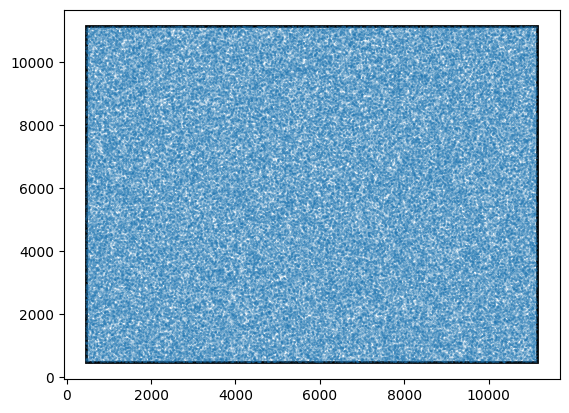


iteration 1


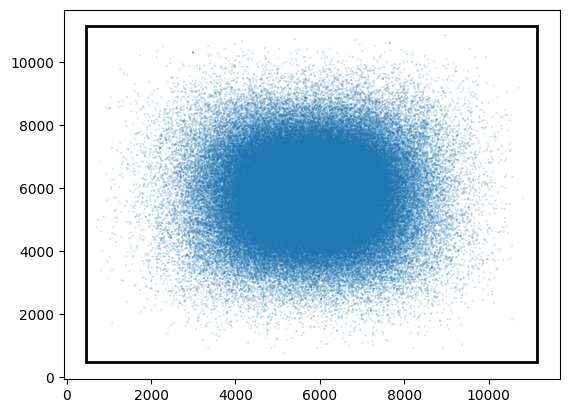


iteration 2


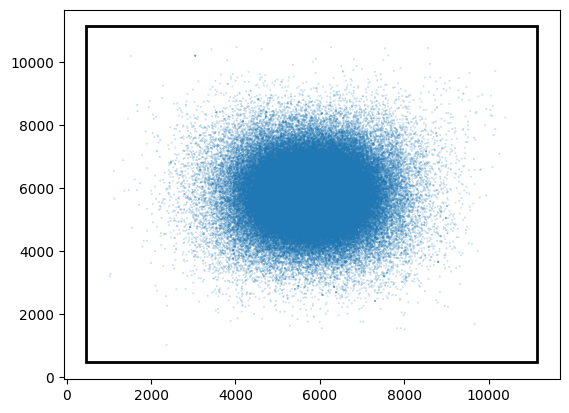


iteration 5


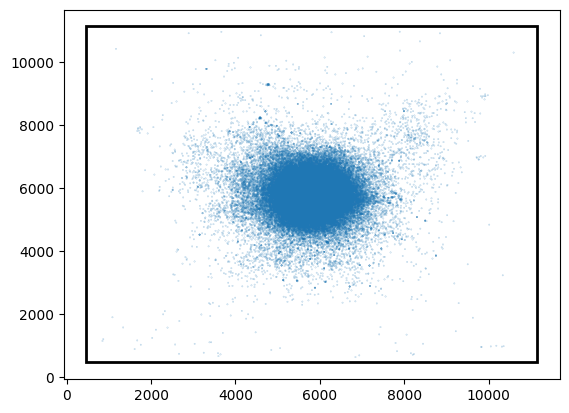


iteration 10


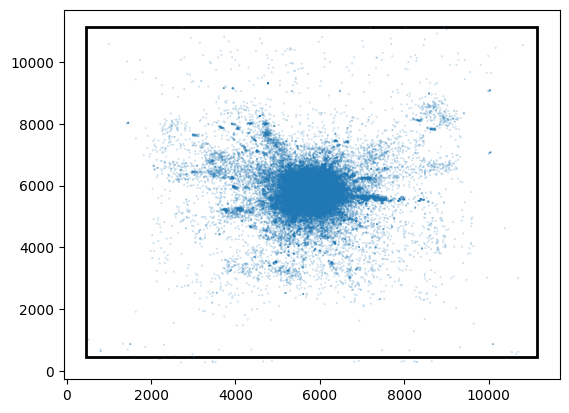


iteration 20


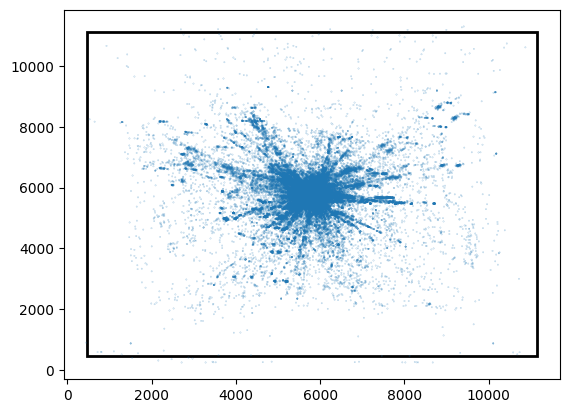


iteration 50


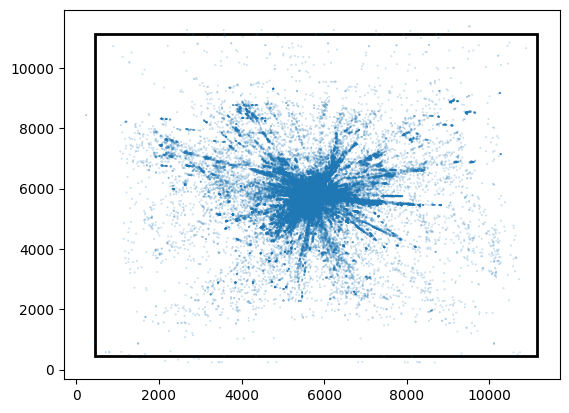


iteration 100


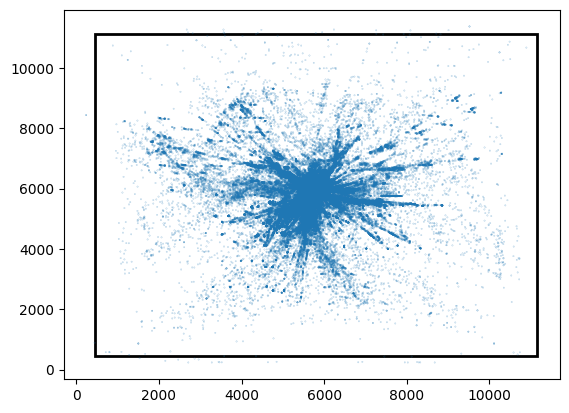


iteration 200


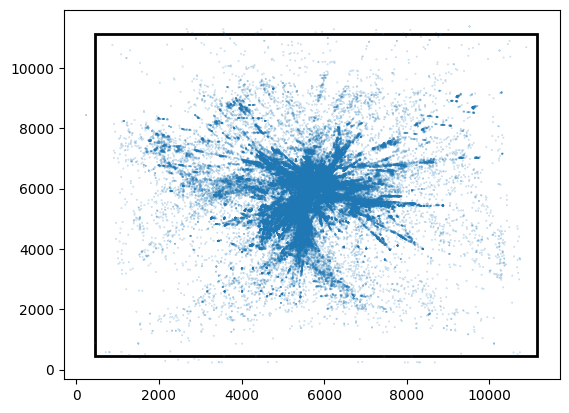


iteration 500


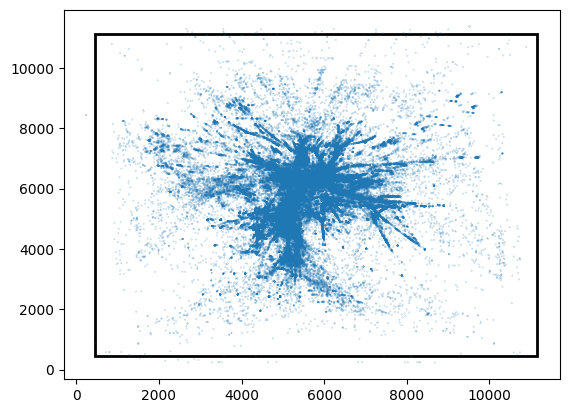


iteration 1000


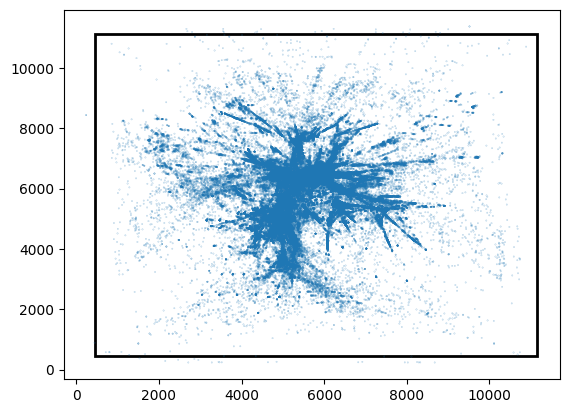

In [3]:
transformer = NetlistTransformer()
transformer.readFromBookshelf()
transformer.init()
iters = [0,1,2,5,10,20,50,100,200,500,1000]
last = 0
plot = True
for num in iters:
    transformer.move(num - last)
    if plot:
        print(f'iteration {num}')
        transformer.plot()
        print()
    last = num
transformer.cluster()
transformer.dumpFiles()

In [4]:
vars(transformer)

{'ratio_condense': None,
 'num_nodes': 211447,
 'num_movable_nodes': 210904,
 'num_fixed_nodes': 543,
 'num_edges': 221142,
 'num_pins': 944053,
 'num_supernodes': 15950,
 'movable_node_list': [<item.Node at 0x7f01a81a13c0>,
  ...],
 'fixed_node_list': [<item.Node at 0x7f0193791690>,
 'edge_list': [<item.Edge at 0x7f019365bc40>,
  ...],
 'supernode_list': [<item.SuperNode at 0x7f016f41c520>,
  ...],
 'superedge_list': [],
 'name2node': {'o0': <item.Node at 0x7f01a81a13c0>,
  'o1': <item.Node at 0x7f01a81a1480>,
  'o2': <item.Node at 0x7f01a81a1d50>,
  'o3': <item.Node at 0x7f01a81a3c10>,
  'o4': <item.Node at 0x7f01a81a34c0>,
  'o5': <item.Node at 0x7f01a81a3970>,
  'o6': <item.Node at 0x7f01a81a05b0>,
  'o7': <item.Node at 0x7f01a81a0190>,
  'o8': <item.Node at 0x7f01a81a0bb0>,
  'o9': <item.Node at 0x7f01a81a0e50>,
  'o10': <item.Node at 0x7f01a81a0d90>,
  'o11': <item.Node at 0x7f01a81a16f0>,
  'o12': <item.Node at 0x7f01a81a1600>,
  'o13': <item.Node at 0x7f01a81a09d0>,
  'o14': <i